### Import all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
import time

from keras.utils.np_utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


### Fetch the MNIST dataset from sklearn datasets module

In [2]:
data_set = datasets.fetch_openml("mnist_784", version=1, return_X_y = True)
pixel_values, targets = data_set

### Visualiszing the first digit

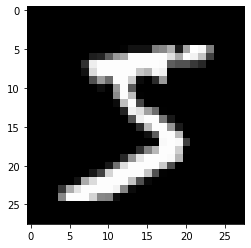

True Label associated with it = 5


In [3]:
#visualizing one single digit
single_digit = pixel_values[0,:].reshape(28,28)
plt.imshow(single_digit, cmap='gray')
plt.show()
#the corresponing true label
print("True Label associated with it =",targets[0])

### Preprocessing the dataset

In [4]:
#since targets are of string type, we convert them into integers
y_int = targets.astype(int)
#now converting to one hot encoded arrays
y = to_categorical(y_int)

#normalize  and convert type to float 32
x = (pixel_values/255).astype('float32')

### splitting into training, validation, and testing data

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

### Creating a Deep Neural Network class

In [6]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer1=self.sizes[1]
        hidden_layer2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            "W1" : np.random.randn(hidden_layer1, input_layer)*np.sqrt(1. / hidden_layer1),
            "W2" : np.random.randn(hidden_layer2, hidden_layer1)*np.sqrt(1. / hidden_layer2),
            "W3" : np.random.randn(output_layer, hidden_layer2)*np.sqrt(1. / input_layer),
            "B1" : np.zeros((hidden_layer1,1), np.float32),
            "B2" : np.zeros((hidden_layer2,1), np.float32),
            "B3" : np.zeros((output_layer,1), np.float32),
        }

        return params
    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))
    
    def tanh(self, x, derivative=False):
        if derivative:
            tanh_x = self.tanh(x)
            return (1-tanh_x*tanh_x)
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def softmax(self, x):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)
    
    def forward_pass(self, x_train):
        params = self.params
        
        #for layer 1 to l-1, i.e., till one but last layer, get the outputs
        #h0 is the input itself
        params["H0"] = x_train.reshape(x_train.shape[0],1)
        
        # input layer to hidden layer 1
        params["A1"] = np.add(np.dot(params["W1"], params["H0"]),  params["B1"])
        params["H1"] = self.sigmoid(params["A1"])

        # hidden layer 1 to hidden layer 2
        params["A2"] = np.add(np.dot(params["W2"], params["H1"]),  params["B2"])
        params["H2"] = self.sigmoid(params["A2"])

        # hidden layer 2 to output layer
        params["A3"] = np.add(np.dot(params["W3"], params["H2"]),  params["B3"])
        params["H3"] = self.softmax(params["A3"])
        
        #return the predicted out that is H3
        return params["H3"]
    
    def backward_pass(self, y_train, output):
        
        #Back Propagation to learn the weights and biases
        #we will get the output from the forward pass
        params = self.params
        change_w = {}
        
        #y_train is the one hot encoded vector corresponding to the true label
        y_train = y_train.reshape(y_train.shape[0],1)
        
        # Calculate W3 update
        error = output - y_train
        change_w['W3'] = np.dot(error, params["H2"].T)
        change_w['B3'] = error

        # Calculate W2 update
        # hadamard operation between : [compute the graients wrt to the layer below],[derivative of activation function]
        error = np.multiply(np.dot(params["W3"].T,error),self.sigmoid(params["A2"], derivative=True))
        change_w['W2'] = np.dot(error, params["H1"].T)
        change_w['B2'] = error

        # Calculate W1 update
        # hadamard operation between : [compute the graients wrt to the layer below],[derivative of activation function]
        error = np.multiply(np.dot(params["W2"].T,error),self.sigmoid(params["A1"], derivative=True))
        change_w['W1'] = np.dot(error, params["H0"].T)
        change_w['B1'] = error

        return change_w
    
    def update_network_parameters(self, changes_to_w):
        #Update network parameters according to update rule from Stochastic Gradient Descent.
        #θ = θ - η * ∇J(x, y)
        
        for key, value in changes_to_w.items():
            self.params[key] = np.subtract(self.params[key], self.l_rate * value)
            
    def compute_accuracy(self, x_val, y_val):
        predictions = []
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(1 if pred == np.argmax(y) else 0)
        return np.average(predictions)
    
    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2}'.format(
                iteration+1, time.time() - start_time, accuracy
            ))

In [7]:
#training and validating
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 72.94s, Accuracy: 0.9157142857142857
Epoch: 2, Time Spent: 135.78s, Accuracy: 0.9423809523809524
Epoch: 3, Time Spent: 190.70s, Accuracy: 0.9548412698412698
Epoch: 4, Time Spent: 244.98s, Accuracy: 0.9608730158730159
Epoch: 5, Time Spent: 302.41s, Accuracy: 0.9648412698412698
Epoch: 6, Time Spent: 362.32s, Accuracy: 0.9676984126984127
Epoch: 7, Time Spent: 424.46s, Accuracy: 0.9693650793650793
Epoch: 8, Time Spent: 468.81s, Accuracy: 0.9704761904761905
Epoch: 9, Time Spent: 504.33s, Accuracy: 0.9714285714285714
Epoch: 10, Time Spent: 538.23s, Accuracy: 0.972936507936508


### Testing on unseen data

In [8]:
testing_accuracy = dnn.compute_accuracy(x_test, y_test)
print("Accuracy on Test Set =",testing_accuracy)

Accuracy on Test Set = 0.9681428571428572
